# KNN

## Choosing k in k-Nearest Neighbors
* **k = 1 (small k)**: Model memorizes training data; Very low training error (often 0); High variance: predictions flip easily if data is noisy → **overfitting** ("*If you only ask 1 friend (k=1), your advice may be extreme or noisy.*")
* **Large k**: Model becomes smoother (less sensitive to noise); But risk of underfitting (decision boundary too simple); At the extreme (k = n, all data): prediction = global majority class → **useless**.(*"If you ask everyone (k=n), you just get the majority opinion (bland, underfit)."*)
* **Best practice:**
  * Try multiple k values (e.g. k = 1, 3, 5, 7, …, √n).
  * Use cross-validation to select the k that minimizes error on validation folds.
  * A good heuristic: start with k ≈ √n as a rule of thumb, then tune.
  
Intuitively, closer neighbors should count more.

```KNeighborsClassifier(n_neighbors=k, weights="distance")```

* weights=“uniform” (default): each of the k neighbors counts equally.
* weights=“distance”: closer neighbors get more weight (1/distance).
* **Effect: reduces the risk of far-away, less relevant points dominating the vote.**

## Example
* **k=1 (Overfit)**: **boundary is very jagged**, perfectly memorizing training data → poor generalization.
* **k=15, uniform weights: smoother boundary** → good balance, ignores small noise.
* k=15, distance weights: similar smoothness, but **boundary leans more toward closer neighbors** → often improves accuracy when far-away points would distort the vote.

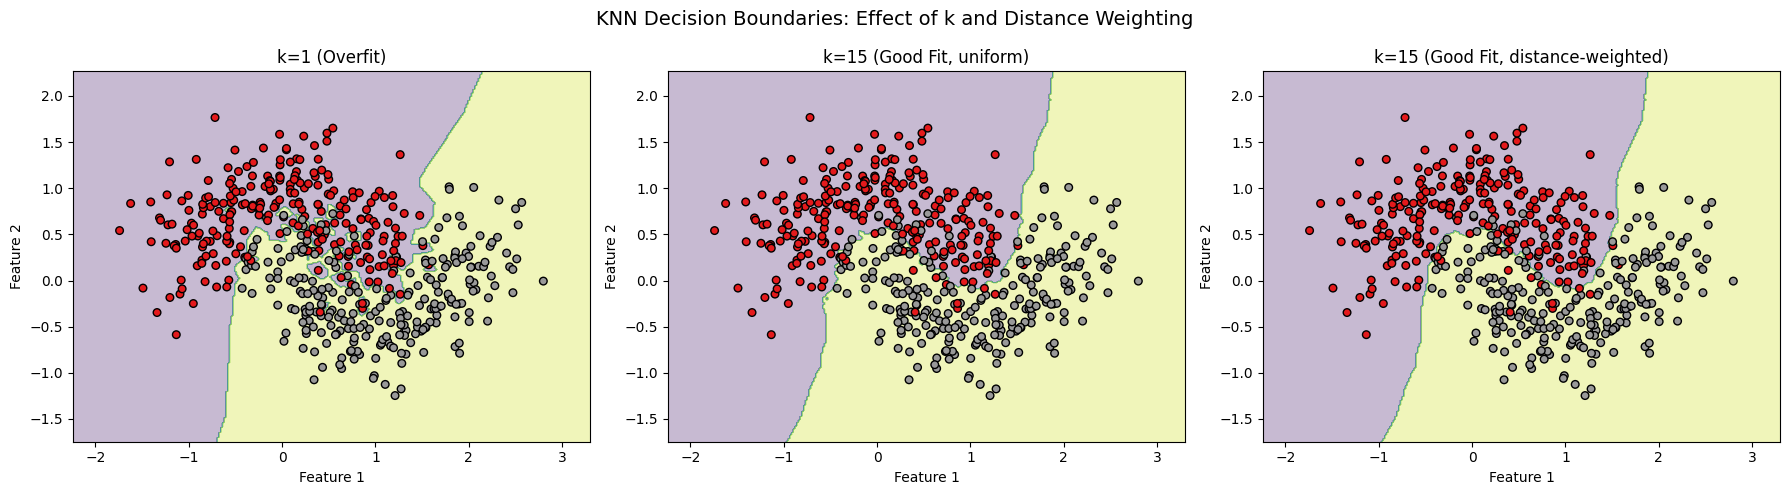

In [1]:
# Visualizing Overfitting with KNN Classifier
# This script demonstrates how different values of k and distance weighting affect the decision boundary of a KNN classifier.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier

# Generate 2D classification dataset (two moons)
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# Create meshgrid for decision boundary plotting
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Configurations: (k, weights)
configs = [(1, 'uniform', "k=1 (Overfit)"),
           (15, 'uniform', "k=15 (Good Fit, uniform)"),
           (15, 'distance', "k=15 (Good Fit, distance-weighted)")]

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for ax, (k, w, title) in zip(axes, configs):
    # Train classifier
    clf = KNeighborsClassifier(n_neighbors=k, weights=w)
    clf.fit(X, y)

    # Predict on meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1, s=30)
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

plt.suptitle("KNN Decision Boundaries: Effect of k and Distance Weighting", fontsize=14)
plt.tight_layout()
plt.show()

> Though: Why visuals aren’t enough. The real question is: which one generalizes better to unseen data? That can’t be judged reliably just from looking at the boundary — you need a **quantitative check**.

## How to pick *k*
1. Cross-Validation (CV): Pick the k with the best mean validation accuracy (or F1, AUC, etc., depending on the problem).
2. Learning Curves: Check how training vs validation error changes with dataset size (helps detect underfitting vs overfitting).
3. Weighting (uniform vs distance): If you notice imbalanced clusters (e.g., one class surrounds the other), distance weighting can help (Again, test this choice via CV).

### Cross-validation accuracy curve vs. k

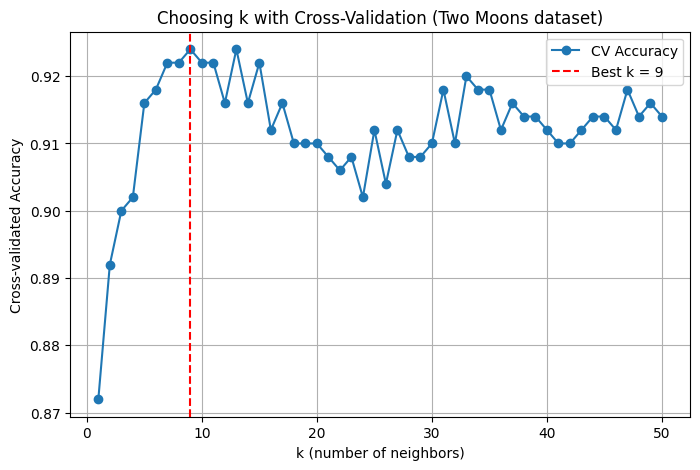

In [2]:
from sklearn.model_selection import cross_val_score

# Range of k values to test
k_values = range(1, 51)
cv_scores = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    # 5-fold cross-validation accuracy
    scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

# Plot accuracy vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, cv_scores, "o-", label="CV Accuracy")
plt.xlabel("k (number of neighbors)")
plt.ylabel("Cross-validated Accuracy")
plt.title("Choosing k with Cross-Validation (Two Moons dataset)")
plt.axvline(k_values[np.argmax(cv_scores)], color="red", linestyle="--", 
            label=f"Best k = {np.argmax(cv_scores)+1}")
plt.legend()
plt.grid(True)
plt.show()

### Training vs Cross-Validation Accuracy accuracy and uncertainty shading

* Curve = mean cross-validated accuracy.
* Shaded band = ±1 standard deviation across folds (stability).
* Red dashed line = best k (around 15 here, ~94% accuracy).

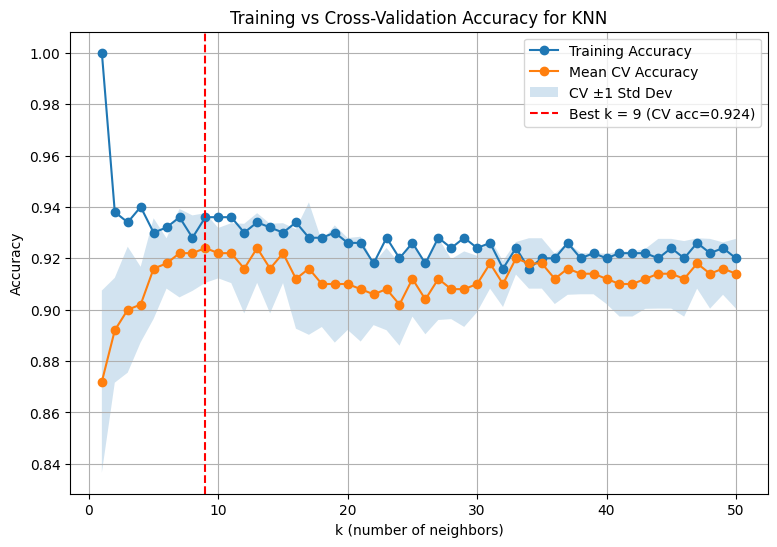

In [4]:
# Compute training accuracy for each k alongside CV accuracy
train_scores = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    train_scores.append(clf.score(X, y))  # accuracy on full training set

train_scores = np.array(train_scores)

# Plot training vs CV accuracy
plt.figure(figsize=(9,6))
plt.plot(k_values, train_scores, "o-", label="Training Accuracy")
plt.plot(k_values, cv_means, "o-", label="Mean CV Accuracy")
plt.fill_between(k_values, cv_means - cv_stds, cv_means + cv_stds,
                 alpha=0.2, label="CV ±1 Std Dev")
plt.axvline(best_k, color="red", linestyle="--",
            label=f"Best k = {best_k} (CV acc={best_acc:.3f})")
plt.xlabel("k (number of neighbors)")
plt.ylabel("Accuracy")
plt.title("Training vs Cross-Validation Accuracy for KNN")
plt.legend()
plt.grid(True)
plt.show()

* Training accuracy (blue):
    * At k=1, it’s perfect (1.0) because the model memorizes → overfitting.
    * As k increases, training accuracy drops (the model smooths more).

* Cross-validation accuracy (orange with shaded band):
    * Starts lower at k=1 (poor generalization).
    * Peaks around k≈15 (best balance).
    * Declines slowly for large k (underfitting).

* This side-by-side view makes the bias–variance tradeoff really clear:
    * Small k = high variance (overfit).
    * Large k = high bias (underfit).
    * Middle k = best generalization.
